# Backend

## Crime Analysis Dashboard App

In [88]:
#Import Libraries
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.ops import triangulate
from shapely.geometry import Polygon
import mapbox_earcut as earcut
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

## Get Police Force Table

In [4]:

def get_forces():

    """ 
    
    Defines the function to call the API and retrieve the police forces data table.
    
    Input: None.
    
    Output: Dataframe containing all the police forece ids and names.
    
    """

    # Defines the connection to the API
    url = "https://data.police.uk/api/forces"
    response = requests.get(url)

    # Raises exception if connection fails
    if response.status_code != 200:                                 
        raise Exception(f"API error: {response.status_code}")           
    
    # Converts responce to json
    data = response.json()

    # Converts json to dataframe
    df = pd.DataFrame(data)

    # Rename ID and name columns
    df.rename(columns={"id": "police_force_id", "name": "police_force_name"}, inplace=True)

    # Returns dataframe
    return df

# Defines the police force dataframe
df_forces = get_forces()

print(df_forces.head())

     police_force_id               police_force_name
0  avon-and-somerset  Avon and Somerset Constabulary
1       bedfordshire             Bedfordshire Police
2     cambridgeshire     Cambridgeshire Constabulary
3           cheshire           Cheshire Constabulary
4     city-of-london           City of London Police


## Get Neighbourhood Table

In [65]:

# INPUT FROM USER
police_force_ids = ["bedfordshire"]  

def get_neighbourhood(id):

    """

    Defines the function to call the API and retrieve the neighbourhood data table.

    Input: Police force ID.

    Output: Dataframe containing the neighbouthood id, name and which police force id it belongs to.

    """

    # Defines the connection to the API
    url = f"https://data.police.uk/api/{id}/neighbourhoods"     # Defines the API url 
    response = requests.get(url)                                # Defines the responce after we 'get' the url
    
    # Raises exception if connection fails
    if response.status_code != 200:
        raise Exception(f"API error: {response.status_code}")
    
    # Converts responce to json 
    data = response.json()

    # Converts json to dataframe
    df = pd.DataFrame(data)

    # Adds police force ID
    df['police_force_id'] = id

    # Renames the ID and name columns
    df.rename(columns={"id": "neighbourhood_id", "name": "neighbourhood_name"}, inplace=True)

    # Returns dataframe
    return df

# Empty list of neighbourhood dataframes 
df_neighbourhoods_list =[]

# Appends each neighbourhood dataframe to the list
for id in police_force_ids:
    df_neighbourhoods_list.append(get_neighbourhood(id))

# Unions the list of dataframes into one
df_neighbourhoods = pd.concat(df_neighbourhoods_list)

print(df_neighbourhoods.sample(5))

   neighbourhood_id                neighbourhood_name police_force_id
8               LU1          Luton and North and West    bedfordshire
1               BD3  Wilstead, Shortstown, Willington    bedfordshire
9               LU2              Luton South and East    bedfordshire
6               CB4               Dunstable and Rural    bedfordshire
15              NU3    Harpur, Brickhill and De Parys    bedfordshire


## Get Neighbourhood Boundaries Table

In [66]:

def get_neighbourhood_boundaries(neighbourhood_id):

    """

    Defines the function to call the API and retrieve the neighbourhood boundaries data table.

    Input: Neighbourhood ID.

    Output: Corresponding boundary polygon string.
    
    """

    # Finds the input's corresponding police force ID 
    police_force_id = df_neighbourhoods.loc[df_neighbourhoods["neighbourhood_id"] == neighbourhood_id, "police_force_id"].iloc[0]

    # Defines the connection to the API
    url = f"https://data.police.uk/api/{police_force_id}/{neighbourhood_id}/boundary"
    response = requests.get(url)
    
    # Raises exception if connection fails
    if response.status_code != 200:
        raise Exception(f"API error: {response.status_code}")
    
    # Convert responce to json
    data = response.json()

    # Convert to polygon string format
    polygon_str = ":".join(
        f"{float(item['latitude'])},{float(item['longitude'])}"
        for item in data
    )

    # Returns polygon
    return polygon_str

# Makes a copy of the neighbourhoods dataframe
df_neighbourhood_boundaries = df_neighbourhoods.copy()

# Initiates empty boundary list 
boundary_list = []

# Loops through all neighbourhood ID's and appends the boundary polygon to the list
for neighbourhood_id in df_neighbourhood_boundaries["neighbourhood_id"]:
    boundary_list.append(get_neighbourhood_boundaries(neighbourhood_id))

# Defines the boundary list as a new column in the dataframe
df_neighbourhood_boundaries["neighbourhood_boundary"] = boundary_list

print(df_neighbourhood_boundaries.head())

  neighbourhood_id                         neighbourhood_name police_force_id  \
0              BD2                   Bromham, Oakley, Wootton    bedfordshire   
1              BD3           Wilstead, Shortstown, Willington    bedfordshire   
2              BD5                          Riseley, Wyboston    bedfordshire   
3              CB1  Flitwick, Ampthill, Marston and Cranfield    bedfordshire   
4              CB2    Biggleswade, Sandy, Potton and Shefford    bedfordshire   

                              neighbourhood_boundary  
0  52.200075358,-0.548369711:52.200155837,-0.5484...  
1  52.201040284,-0.437150426:52.20106348,-0.43761...  
2  52.322913907,-0.465104578:52.322953267,-0.4653...  
3  52.110251611,-0.591229997:52.11069521,-0.59140...  
4  52.190902794,-0.287653471:52.190925829,-0.2891...  


## Get Street-Level Crimes Table

In [78]:
def get_kml(neighbourhood_id): 
    
    """

    Defines the function to call the API and retrieve the neighbourhood KML file.

    Input: Neighbourhood ID.

    Output: Corresponding KML file content.
    
    """

    # Get pathfile from neighbourhood ID
    return f"C:/Users/benco/Downloads/force_kmls/data/{neighbourhood_id}.kml"

    # Return KML content
    return path




def get_street_level_crimes(poly_str):

    """
    
    Defines the function to call the API and retrieve the neighbourhood boundaries data table.

    Input: A polygon string defining the area to get street-level crimes for.

    Output: Street-level crime dataframe for the neighbourhood.

    """

    # Defines the connection to the API
    url = f"https://data.police.uk/api/crimes-street/all-crime?poly={poly_str}"
    response = requests.get(url)
    
    # Raises exception if connection fails
    if response.status_code != 200:
        raise Exception(f"API error: {response.status_code}")
    
    # Convert responce to json
    data = response.json()

    # Converts json to dataframe
    df = pd.DataFrame(data)

    # Returns dataframe
    return df



def load_polygon_from_kml(filepath):

    """

    A function to load a polygon from a KML file.

    Input: Filepath to the KML file.

    Output: Shapely polygon object.

    """

    # Loads KML file using geopandas
    gdf = gpd.read_file(filepath, driver="LIBKML")

    # Many KMLs contain a single feature
    polygon = gdf.geometry.iloc[0]

    # Returns polygon
    return polygon



def triangulate_polygon(polygon):

    """

    A function to triangulate a polygon into smaller triangles.

    Input: Shapely polygon object.

    Output: List of Shapely triangle objects.

    """

    # Triangulates polygon
    triangles = triangulate(polygon)

    # Keeps only triangles fully inside the polygon
    triangles = [t for t in triangles if polygon.contains(t.centroid)]

    # Returns list of triangles
    return triangles



def triangle_to_poly_string(triangle):
    
    """

    A function to convert a triangle to a polygon string.

    Input: Shapely triangle object.

    Output: Polygon string.

    """

    # Gets triangle coordinates
    coords = list(triangle.exterior.coords)[:-1]  # remove repeated closing point

    # convert (lng, lat) → (lat, lng)
    return ":".join(
        f"{coord[1]},{coord[0]}"
        for coord in coords
    )



def simplify_polygon(polygon, tolerance=0.0005):

    """

    Reduce polygon complexity while preserving shape.
    Tolerance ≈ 50m at UK latitudes.

    Input: Shapely polygon object, tolerance value.

    Output: Simplified Shapely polygon object.

    """

    # Simplifies polygon
    return polygon.simplify(tolerance, preserve_topology=True)



def process_kml_file_to_dataframe(police_force_id):

    """

    A function to process a KML file and retrieve street-level crime data for the area.

    Input: Filepath to the KML file.

    Output: Street-level crime dataframe for the area.

    """

    # Get KML filepath
    kml_path = get_kml(police_force_id)

    # Loads polygon
    polygon = load_polygon_from_kml(kml_path)

    # Simplifies polygon
    polygon = simplify_polygon(polygon)

    # Triangulates polygon
    triangles = triangulate_polygon(polygon)

    # Initialises a list to collect each triangle's dataframe
    all_dfs = []

    # Gets dataframa for each triangle
    for tri in triangles:
        
        # Converts the triangles to lists of coordiante strings
        poly_str = triangle_to_poly_string(tri)

        # Calls the API and gets the dataframe
        df = get_street_level_crimes(poly_str)

        # Combine dataframes
        all_dfs.append(df)

    # Checks that data has been collected, returns blank dataframe if no data is collected
    if len(all_dfs) == 0:
        return pd.DataFrame()

    # Combines all dataframes
    final_df = pd.concat(all_dfs, ignore_index=True)

    final_df["police_force_id"] = police_force_id

    # Returns combined dataframe
    return final_df


df_crimes = process_kml_file_to_dataframe("bedfordshire")
print(df_crimes.head())



        category location_type  \
0  vehicle-crime         Force   
1  vehicle-crime         Force   
2  vehicle-crime         Force   
3  vehicle-crime         Force   
4       burglary         Force   

                                            location context  \
0  {'latitude': '52.276206', 'street': {'id': 194...           
1  {'latitude': '52.276206', 'street': {'id': 194...           
2  {'latitude': '52.289054', 'street': {'id': 194...           
3  {'latitude': '52.301284', 'street': {'id': 194...           
4  {'latitude': '52.208093', 'street': {'id': 195...           

                                      outcome_status  \
0  {'category': 'Investigation complete; no suspe...   
1  {'category': 'Investigation complete; no suspe...   
2  {'category': 'Unable to prosecute suspect', 'd...   
3  {'category': 'Under investigation', 'date': '2...   
4  {'category': 'Investigation complete; no suspe...   

                                       persistent_id         id  \
0  878

## Get Specific Neighbourhood Table

In [11]:
def get_specific_neighbourhood(police_force_id, neighbourhood_id):

    """

    A function to get data for a specific neighbourhood.

    Input: Police force ID. Neighbourhood ID.

    Output: Dataframe containing all data for the specific neighbourhood.


    """

    # Defines the connection to the API
    url = f"https://data.police.uk/api/{police_force_id}/{neighbourhood_id}"
    response = requests.get(url)
    
    # Raises exception if connection fails
    if response.status_code != 200:
        raise Exception(f"API error: {response.status_code}")
    
    # Convert responce to json
    data = response.json()

    # Converts json to dataframe
    df = pd.json_normalize(data)

    # Returns dataframe
    return df
    
    
def get_specific_neighnourhoods_from_police_force(police_force_id, df_neighbourhoods=df_neighbourhoods):

    """

    A function to get all specific neighbourhoods for a police force ID.

    Input: Police force ID. Neighbourhoods dataframe.

    Output: Dataframe containing all neighbourhoods for the specific police force ID.

    """

    # Initiates empty list to collect dataframes
    specific_neighbourhood_list = []

    # Loops through all neighbourhood ID's for the specific police force ID
    for neighbourhood_id in df_neighbourhoods["neighbourhood_id"][df_neighbourhoods["police_force_id"] == police_force_id]:

        # Calls the API and gets the dataframe
        df = get_specific_neighbourhood(police_force_id, neighbourhood_id)

        # Appends dataframe to the list
        specific_neighbourhood_list.append(df)

    # Unions the list of dataframes into one
    df = pd.concat(specific_neighbourhood_list, ignore_index=True)

    # Adds police force ID column
    df["police_force_id"] = police_force_id

    # Returns datatframe
    return df



df_specific_neighbourhoods = get_specific_neighnourhoods_from_police_force("bedfordshire")
print(df_specific_neighbourhoods.head())



    id                                       name  \
0  BD2                   Bromham, Oakley, Wootton   
1  BD3           Wilstead, Shortstown, Willington   
2  BD5                          Riseley, Wyboston   
3  CB1  Flitwick, Ampthill, Marston and Cranfield   
4  CB2    Biggleswade, Sandy, Potton and Shefford   

                                           url_force population links  \
0  https://www.police.uk/pu/your-area/bedfordshir...          0    []   
1  https://www.police.uk/pu/your-area/bedfordshir...          0    []   
2  https://www.police.uk/pu/your-area/bedfordshir...          0    []   
3  https://www.police.uk/pu/your-area/bedfordshir...          0    []   
4  https://www.police.uk/pu/your-area/bedfordshir...          0    []   

  locations centre.latitude centre.longitude  \
0        []         52.1386        -0.551294   
1        []         52.1278        -0.427471   
2        []         52.2442        -0.454736   
3        []         52.0219        -0.482151   
4 

---

# Web Scraping Population Data


In [83]:
df_population = pd.read_csv("C:/Users/benco/OneDrive/Documents/Rockborne/Week 11/Project/Main/population_data.csv")
df_population.head()

,police_force_id,population
0,thames valley,2.4m
1,hertfordshire,1.2m
2,bedfordshire,0.682m
3,northamptonshire,0.757m


---

# Cleaning - Street Level Crime

In [ ]:
df = df_crimes.copy()

In [ ]:
df.isna().sum()

category               0
location_type          0
location               0
context                0
outcome_status      1748
persistent_id          0
id                     0
location_subtype       0
month                  0
dtype: int64

## Filling Nulls

In [70]:
# Fills nulls in the outcome column with 'Unknown'
def fill_blank_outcome_status(df):

    """

    A function to fill blank outcome status values with 'Unknown'.

    Input: Crime dataframe.

    Output: Crime dataframe with filled outcome status values.

    """

    # Fills nulls in the outcome column with 'Unknown'
    df["outcome_status"] = df["outcome_status"].fillna("Unknown")

    # Returns dataframe
    return df


df = fill_blank_outcome_status(df_crimes)
df.isna().sum()

category            0
location_type       0
location            0
context             0
outcome_status      0
persistent_id       0
id                  0
location_subtype    0
month               0
dtype: int64

## Checking for Duplicates

In [71]:
def remove_duplicates(df):
    if "id" in df.columns:
        return df.drop_duplicates(subset=["id"]).reset_index(drop=True)

    subset = [c for c in ["latitude", "longitude", "month", "category"] if c in df.columns]
    return df.drop_duplicates(subset=subset).reset_index(drop=True)

df = remove_duplicates(df)
df.shape

(5112, 9)

## Check Datatypes


In [ ]:
df.dtypes

category             object
location_type        object
context              object
outcome_status       object
persistent_id        object
id                    int64
location_subtype     object
month                object
latitude            float64
longitude           float64
street_name          object
dtype: object

# Separating Location Column

In [72]:
def extract_coordinates_and_street(df):

    """

    A function to extract latitude, longitude and street name from the location column.

    Input: Crime dataframe.

    Output: Crime dataframe with new latitude, longitude and street name columns.

    """

    # Extracts coordinates and street name from location column
    coords = pd.json_normalize(df["location"])
    df["latitude"] = pd.to_numeric(coords["latitude"], errors="coerce")
    df["longitude"] = pd.to_numeric(coords["longitude"], errors="coerce")
    df["street_name"] = coords["street.name"]
    df.drop(columns=["location"], inplace=True)
    
    # Returns dataframe
    return df

df = extract_coordinates_and_street(df)
df.head()

,category,location_type,context,outcome_status,persistent_id,id,location_subtype,month,latitude,longitude,street_name
0,vehicle-crime,Force,,{'category': 'Investigation complete; no suspe...,878958d357620bcede7814df7396bc02f2840dbf853050...,131584336,,2025-10,52.276206,-0.602470,On or near Cambridge Street
1,vehicle-crime,Force,,{'category': 'Investigation complete; no suspe...,8dbda9108ab2a2a9b4415d668d3c923a9c247db818ab92...,131584186,,2025-10,52.276206,-0.602470,On or near Cambridge Street
2,vehicle-crime,Force,,"{'category': 'Unable to prosecute suspect', 'd...",70cc172375bb5e7a981e62388025ad381234cf564d626b...,131584139,,2025-10,52.289054,-0.517686,On or near High Top Barns
3,vehicle-crime,Force,,"{'category': 'Under investigation', 'date': '2...",0b0a4b395eb20a8921a7d2f23536971bee0322aa0047c9...,131584218,,2025-10,52.301284,-0.471285,On or near Shelton Road
4,burglary,Force,,{'category': 'Investigation complete; no suspe...,a70d901945b19e53e0030ada6f30c52e42ab746401fc48...,131584020,,2025-10,52.208093,-0.270233,On or near Alington Road


## Separating Date Column

In [73]:
def extract_date_components(df):

    """

    A function to extract year and month from the month column.

    Input: Crime dataframe.

    Output: Crime dataframe with new year and month columns.

    """

    # Converts month column to datetime format
    df["month"] = pd.to_datetime(df["month"], format="%Y-%m")

    # Extracts year and month from month column
    df["year"] = df["month"].dt.year
    df["month"] = df["month"].dt.month

    # Returns dataframe
    return df

df = extract_date_components(df)
df.head()

,category,location_type,context,outcome_status,persistent_id,id,location_subtype,month,latitude,longitude,street_name,year
0,vehicle-crime,Force,,{'category': 'Investigation complete; no suspe...,878958d357620bcede7814df7396bc02f2840dbf853050...,131584336,,10,52.276206,-0.602470,On or near Cambridge Street,2025
1,vehicle-crime,Force,,{'category': 'Investigation complete; no suspe...,8dbda9108ab2a2a9b4415d668d3c923a9c247db818ab92...,131584186,,10,52.276206,-0.602470,On or near Cambridge Street,2025
2,vehicle-crime,Force,,"{'category': 'Unable to prosecute suspect', 'd...",70cc172375bb5e7a981e62388025ad381234cf564d626b...,131584139,,10,52.289054,-0.517686,On or near High Top Barns,2025
3,vehicle-crime,Force,,"{'category': 'Under investigation', 'date': '2...",0b0a4b395eb20a8921a7d2f23536971bee0322aa0047c9...,131584218,,10,52.301284,-0.471285,On or near Shelton Road,2025
4,burglary,Force,,{'category': 'Investigation complete; no suspe...,a70d901945b19e53e0030ada6f30c52e42ab746401fc48...,131584020,,10,52.208093,-0.270233,On or near Alington Road,2025


---

# Cleaning - Specific Neighbourhood

In [49]:
df_specific_neighbourhoods.sample(5)

,id,name,url_force,population,links,locations,centre.latitude,centre.longitude,contact_details.email,police_force_id
10,LU3,Luton Central,https://www.beds.police.uk/area/your-area/bedf...,0,[],[],51.8975,-0.433363,Central-CPT@beds.police.uk,bedfordshire
12,LU5,Luton Airport,https://www.police.uk/pu/your-area/bedfordshir...,0,[],[],51.8783,-0.37011,AirportUnit@beds.police.uk,bedfordshire
13,NU1,"Kingsbrook, Kempston, Cauldwell",https://www.police.uk/pu/your-area/bedfordshir...,0,[],[],52.1157,-0.467834,CommunityNorthBedfordUrban@beds.police.uk,bedfordshire
3,CB1,"Flitwick, Ampthill, Marston and Cranfield",https://www.police.uk/pu/your-area/bedfordshir...,0,[],[],52.0219,-0.482151,AmpthillCPT@beds.police.uk,bedfordshire
16,NU4,"Putnoe, Goldington, Newnham",https://www.police.uk/pu/your-area/bedfordshir...,0,[],[],52.1449,-0.42817,CommunityNorthBedfordUrban@beds.police.uk,bedfordshire


---

# Cleaning - Population Data 

In [84]:
def clean_population(pop):

    """

    A function to clean the population column.

    Input: Population.

    Output: Cleaned population.

    """

    # Removes m from population values
    pop = pop.replace("m", "")

    # Converts population to a float
    pop = float(pop)

    # Changes decimal to millions
    pop = pop * 1000000

    # Returns cleaned population
    return int(pop)


def clean_population_df(df_population):

    """

    A function to clean the population dataframe.

    Input: Population dataframe.

    Output: Cleaned population dataframe.

    """

    # Cleans population column
    df_population["population"] = df_population["population"].apply(clean_population)

    # Returns cleaned dataframe
    return df_population

df_population = clean_population_df(df_population)
df_population.head()

,police_force_id,population
0,thames valley,2400000
1,hertfordshire,1200000
2,bedfordshire,682000
3,northamptonshire,757000


## Combining Cleaning into one Step

In [79]:
def cleaning(df):

    """

    A function to clean the crime dataframe.

    Input: Crime dataframe.

    Output: Cleaned crime dataframe.

    """

    # Fills blank outcome status values
    df = fill_blank_outcome_status(df)

    # Removes duplicate rows
    df = remove_duplicates(df)

    # Extracts latitude, longitude and street name
    df = extract_coordinates_and_street(df)

    # Extracts year and month from month column
    df = extract_date_components(df)

    # Returns cleaned dataframe
    return df

df_crimes = cleaning(df_crimes)

---

# Graphs

## Crime Rate by Region - Lollipop Chart


In [97]:
# THEME

theme = ["whitegrid", "viridis"]

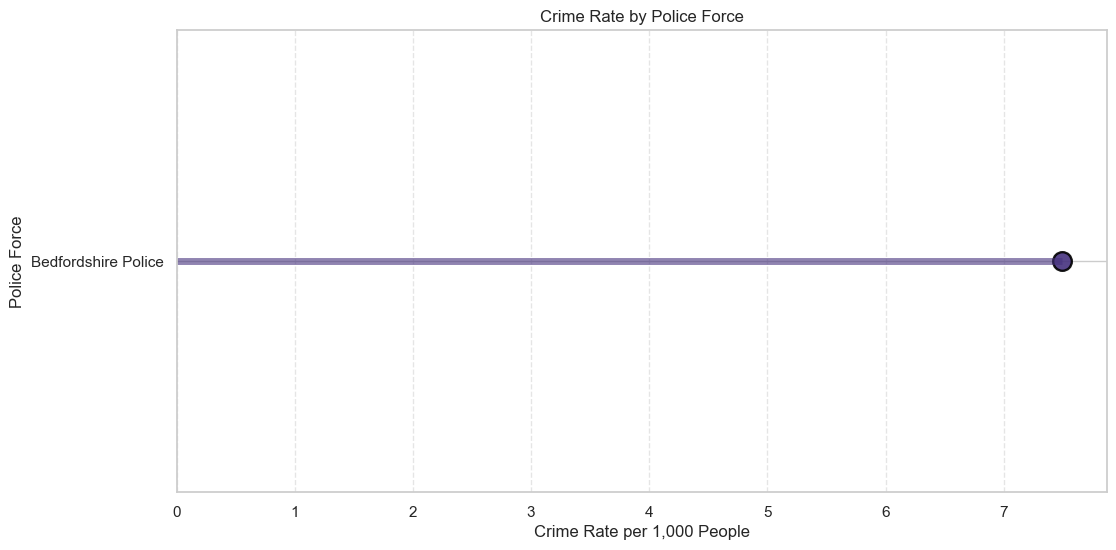

     police_force_name  crime_count  population  crime_rate_per_1000
0  Bedfordshire Police         5112      682000             7.495601


In [107]:
def get_columns_for_crime_rate_by_region(df_crimes, df_population, df_forces):

    """

    A function to get the necessary columns for calculating crime rate by region.

    Input: Crime dataframe. Population dataframe. Police forces dataframe.

    Output: Dataframe with necessary columns for calculating crime rate by region.

    """

    # Groups crimes by region and counts number of crimes
    df_crime_counts = df_crimes.groupby("police_force_id").size().reset_index(name="crime_count")

    # Merges crime counts with population data
    df_merged_1 = pd.merge(df_crime_counts, df_population, on="police_force_id", how="left")

    # Merges crime counts and population data with police forces data
    df_merged_2 = pd.merge(df_merged_1, df_forces, on="police_force_id", how="left")

    # Selects necessary columns
    df_result = df_merged_2[["police_force_name", "crime_count", "population"]]

    # Returns dataframe
    return df_result


def add_crime_rate_column(df):

    """

    A function to calculate crime rate by region.

    Input: Dataframe with necessary columns for calculating crime rate by region.

    Output: Dataframe with crime rate by region.

    """

    # Calculates crime rate per 1,000 people
    df["crime_rate_per_1000"] = (df["crime_count"] / df["population"]) * 1000

    # Returns dataframe
    return df



def make_lollipop_chart(df, theme):

    """

    A function to create a lollipop chart of crime rate by region.

    Input: Dataframe with crime rate by region.

    Output: Lollipop chart.

    """

    # Set the theme for the plot
    sns.set_theme(style=theme[0], palette=theme[1])

    # Sort for nicer plotting
    df = df.sort_values("crime_rate_per_1000")

    plt.figure(figsize=(12, 6))

    # Draw stems (lines from 0 to value)
    plt.hlines(
        y=df["police_force_name"],
        xmin=0,
        xmax=df["crime_rate_per_1000"],
        linewidth=5,
        alpha=0.6
    )

    # Draw lollipop heads
    sns.scatterplot(
        x="crime_rate_per_1000",
        y="police_force_name",
        size="population",
        sizes=(180, 1200),
        data=df,
        legend=False,
        edgecolor="black",
        linewidth=1.7,
        alpha=0.9
    )

    plt.xlabel("Crime Rate per 1,000 People")
    plt.ylabel("Police Force")
    plt.title("Crime Rate by Police Force")
    plt.xlim(left=0)
    plt.grid(axis="x", linestyle="--", alpha=0.5)

    plt.show()



def crime_rate_by_region_info(df_crime_rate):

    """ 

    A function to display information about crime rate by region for the LLM.

    Input: Dataframe with crime rate by region.

    Output: String containing information about crime rate by region.

    """

    # Gets descriptive statistics
    info = df_crime_rate.to_string()

    # Returns information string
    return info


df_crime_rate = get_columns_for_crime_rate_by_region(df_crimes, df_population, df_forces)
df_crime_rate = add_crime_rate_column(df_crime_rate)

make_lollipop_chart(df_crime_rate, theme)
print(crime_rate_by_region_info(df_crime_rate))